In [1]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode


tavily_tool = TavilySearchResults(max_results=2)
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

In [2]:
from langchain_groq.chat_models import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm_with_tools = llm.bind_tools(tools=tools)

In [3]:
from langgraph.graph import StateGraph,MessagesState,START,END
def chat_model(state:MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [4]:
def route(state:MessagesState):
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "tools"
    else:
        return END

In [5]:
workflow = StateGraph(MessagesState)

workflow.add_node("chatbot",chat_model)
workflow.add_node("tools",tool_node)

workflow.add_edge(START,"chatbot")
workflow.add_conditional_edges("chatbot",route,{"tools": "tools",END: END})
workflow.add_edge("tools","chatbot")

app = workflow.compile()

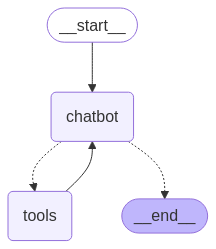

In [6]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
app.invoke({"messages":[{"role":"user","content":"What is the capital of France?"}]})

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}, id='64d3f072-ed66-455c-93c1-4a5981d5391e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c93j', 'function': {'arguments': '{"query":"What is the capital of France?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 988, 'total_tokens': 1080, 'completion_time': 0.167272727, 'prompt_time': 0.034668913, 'queue_time': 0.233592526, 'total_time': 0.20194164}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-18c86bf0-13b0-4054-b9ef-8452468ec656-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'What is the capital of France?'}, 'id': 'call_c93j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 988, 'output_tokens': 92, 'total_tokens': 1080}),
  ToolMessage(con